# Kevitsa: Magnetic Simulation

In this notebook, we will attemp to estimate the strength and orientation of remanent magnetization over the Kevitsa intrusion.
The effect of remanence is quite obvious when looking at the observed TMI data.
We will do this interactively with the help of an IPython widget.

There has been a Master's thesis dedicated to the remanence of the central Dunite unit. The study looked at core samples on two boreholes: KV200 and KV297. Lab measurements reported Koenigsberger ratios of up to +10, with remanence inclination in the range: $$[-40^\circ, -75^\circ].$$ The declination of remanence remained uncertain however due to the lack of oriented core.

We can potentially confirm these findings with a simple magnetic forward modeling experiment... 

**Reference**

Markku Montonen, 2012. Induced and remanent magnetization in two  boreholes of the Kevitsa intrusion. University of Helsinki. M.Sc. Thesis 



In [1]:
# Load the necessary packages
from SimPEG import Mesh, Utils, Maps, PF
from SimPEG.Utils import mkvc
from SimPEG.Utils.io_utils import download
import numpy as np
import scipy as sp
import os
import ipywidgets as widgets
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# Download data from the cloud 
url = "https://storage.googleapis.com/simpeg/kevitsa_synthetic/"

cloudfiles = [
    'Mesh_global_100m_padded.msh', 'Kevitsa_AvgSusc.sus', 'Kevitsa_MagSimulated.dat',
    'LithoCode_100m.dat', 'MagSim.dat', 'SimPEG_MAG.inp', 'VTEM_FLT20m_IGRF53260nT.dat'
]
keys = [
    'mesh', 'avgSusc', 'MagSimulated', 'LithoCode', 'MagSim', 'input', 'VTEMdat'
]

files = download([url+f for f in cloudfiles], folder='./KevitsaMag', overwrite=True)
files = dict(zip(keys, files))

driver = PF.MagneticsDriver.MagneticsDriver_Inv(files['input'])

# This how you can get the mesh, data and models
mesh = driver.mesh
susc = driver.m0
rock = driver.mref

   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/Mesh_global_100m_padded.msh
   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/Kevitsa_AvgSusc.sus
   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/Kevitsa_MagSimulated.dat
   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/LithoCode_100m.dat
   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/MagSim.dat
   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/SimPEG_MAG.inp
   saved to: /Users/lindseyjh/git/geosci/computation/notebooks/case-studies/PF/KevitsaMag/VTEM_FLT20m_IGRF53260nT.dat
Download completed!


In [3]:
# Read in the observed data
truData = driver.survey
simData = driver.readMagneticsObservations('VTEM_FLT20m_IGRF53260nT.dat')
locXyz = truData.srcField.rxList[0].locs

In [4]:
# Run the forward on the Dunite, this might take some time.
actv = rock == 7
nC = int(np.sum(actv))

# Create identity map
idenMap = Maps.IdentityMap(nP=nC)

prob = PF.Magnetics.MagneticVector(mesh, chiMap=idenMap, actInd=actv)
simData.pair(prob)

# First time the forward operator is called, it is strored to memory
print(prob.G.shape)

Begin calculation of forward operator: xyz
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!

(29556, 4656)


In [6]:
# Here is where we create the app
# The IPython widget will take care of the buttons 

inc = truData.srcField.param[1]
dec = truData.srcField.param[2]

def FWRSimulator(prob, survey, data, true):
    
    rxloc = survey.srcField.rxList[0].locs

    def FWRmag(ke, inc, dec):

        # Create a magnetization model
        m = mkvc(PF.Magnetics.dipazm_2_xyz(np.ones(nC)*inc, np.ones(nC)*dec)) * ke

        fwr_d = data + np.dot(prob.G,m)

        plt.figure(figsize=(12,8))
        axs = plt.subplot(1,2,2)
        ph = PF.Magnetics.plot_obs_2D(rxloc, fwr_d, marker=False, ax=axs, vmin = -750, vmax=2000, cmap='jet')
        axs.set_yticklabels([])
        axs.set_title('Simulated')

        axs = plt.subplot(1,2,1)
        ph = PF.Magnetics.plot_obs_2D(rxloc, true, marker=False, ax=axs, vmin = -750, vmax=2000, cmap='jet')
        
        plt.show()
        
        
    out = widgets.interactive(
        FWRmag,
        ke = widgets.FloatSlider(min=0,max=2,step=0.01,value=0.1,continuous_update=False),
        inc = widgets.FloatSlider(min=-90,max=90,step=2,value=inc,continuous_update=False),
        dec = widgets.FloatSlider(min=0,max=360,step=2,value=dec,continuous_update=False)
    )
    
    return out

## The Magnetic App

The cell below will plot the true (left) and simulated (right) magnetic data over the Kevitsa intrusion. The goal of this exercise is to test different magnetization orientations and strenght in order to best fit the observed data.

The input parameters are:

**ke**: (effective susceptibility) $$M = \kappa_{e} * |\vec H_0|$$

**inc**: Inclination 

**dec**: Declination

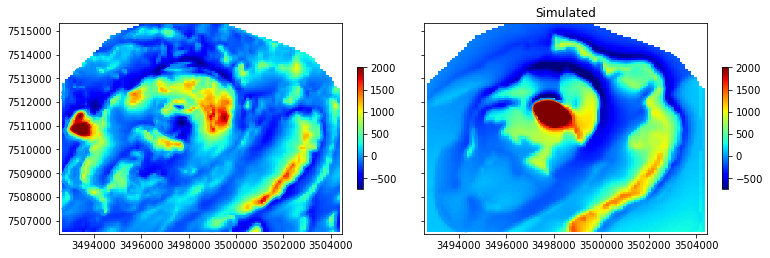

In [7]:
box = FWRSimulator(prob,simData, truData.dobs, simData.dobs)
display(box)